In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
from collections import defaultdict
#from Solver import solver
#import Solver_V2
import Solver_V3
import utilities as util

# Lectura de Datos

In [2]:
df = pd.read_csv("datos_arreglados.csv", encoding="latin1")
df = df[df["ID"] > 60] #esto pues las primeras filas estaban falladas

In [3]:
#df.rename(columns={'Ethical technology assessment?':'Ethical technology assessment'}, inplace=True)

bach = df[df['program'] == 'bachelor'] #selecciona las tuplas de bachelor en un df
mast = df[df['program'] == 'master'] #selecciona las tuplas master en un df

b_aal = bach[bach['campus'] == 'AAL'] #selecciona las tuplas bachelor aal en df
m_aal = mast[mast['campus'] == 'AAL'] #selecciona las tuplas master aal en df

b_cph = bach[bach['campus'] == 'CPH'] #selecciona las tuplas bachelor cph en df
m_cph = mast[mast['campus'] == 'CPH'] #selecciona las tuplas master cph en df

esb = df[df['campus'] == 'ESB'] #selecciona las tuplas esb en df

In [4]:
col1 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most4' 
col2 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most5'
col3 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most6'

cursos_b_aal = sorted(set(b_aal[col1]) | set(b_aal[col2]) | set(b_aal[col3])) #talleres disponibles para bachelor aal, en base a los seleccionados en top 3
cursos_m_aal = sorted(set(m_aal[col1]) | set(m_aal[col2]) | set(m_aal[col3])) #talleres disponibles para master aal,  en base a los seleccionados en top 3

cursos_b_cph = sorted(set(b_cph[col1]) | set(b_cph[col2]) | set(b_cph[col3])) #talleres disponibles para bachelor cph, en base a los seleccionados en top 3
cursos_m_cph = sorted(set(m_cph[col1]) | set(m_cph[col2]) | set(m_cph[col3])) #talleres disponibles para master cph,  en base a los seleccionados en top 3

cursos_esb = sorted(set(esb[col1]) | set(esb[col2]) | set(esb[col3])) #talleres disponibles para esb, en base a los seleccionados en top 3


#selecciona columnas de los nombres de curso, donde cada columna posee NaN, 1, 2, 3 indicando preferencia top 3 o no
pref_b_aal = b_aal[cursos_b_aal] 
pref_m_aal = m_aal[cursos_m_aal] 

pref_b_cph = b_cph[cursos_b_cph]
pref_m_cph = m_cph[cursos_m_cph]

pref_esb = esb[cursos_esb]

In [5]:
pref_esb.head()

,Clarification of individual professional competences,Collaboration across discplines,Creativity and entrepeneurship,Digital and hybrid practices in collaborative work,Digital practices in project work,Ethical technology assessment,Facilitation of productive meeting,Generative AI in study practices?,Interdisciplinary problem design,Leadership and project management,"Motivation, well-being and work-life balance?",Professional communication with external partners,Professional identity development,Psychological safety in team work,Psychological safety in teamwork,SCRUM-techniques in project work?,Systems thinking in engineering
11,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN
16,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0


Establecer preferencias de estudiantes

In [6]:
#ejemplo:
util.get_dict(pref_m_aal, 1)                     # Para saber preferencia de estudiante 
                                                 # s en opcion i. se aplica t_pref[s][i]

{1: 1, 2: 5, 3: 2}

# Implementación

## AAL magister

In [7]:
# Elegir Programa y campus
pref = pref_m_aal

# Setear Parámetros
(S, T, H, C, U, t_pref, D, p) = util.get_par(pref)

D[1] = 1                                # el taller 1 es de día completo
C = [6, 6]                              # capacidad de talleres por horario (AM, PM)
U = [70 for _ in range(pref.shape[1])]  # capacidad de cada taller (todos con 80 cupos)

print("Hay", len(pref), "estudiantes, considerar esto al elegir capacidad y número de talleres")

pref.head()

Hay 393 estudiantes, considerar esto al elegir capacidad y número de talleres


,Clarification of individual professional competences,Creative and systems thinking for complex problem-solving (whole day workshop - you are then attending 1 workshop the whole day),Digital and hybrid practices in collaborative work,Ethical technology assessment,Leadership and project management,Professional communication with external partners,Professional identity development,Psychological safety in team work
13,1.0,3.0,NaN,NaN,NaN,NaN,2.0,NaN
15,NaN,1.0,3.0,NaN,NaN,2.0,NaN,NaN
20,1.0,NaN,NaN,3.0,NaN,NaN,2.0,NaN
21,1.0,NaN,NaN,3.0,NaN,NaN,2.0,NaN
24,3.0,NaN,2.0,NaN,1.0,NaN,NaN,NaN


In [8]:
#p = [8, 4, 2] #por si quiero modificar los pesos estándar [10, 5, 3]
print(f'Usando pesos: {p}')

Usando pesos: [10, 5, 3]


In [9]:
%%time
# 0 al final para que no hable tanto, 1 si quiero más infor
#modelo, y, z, w = solver(S, T, H, C, U, t_pref, D, p, 0)
modelo, y, z, w = Solver_V3.solver(S, T, H, C, U, t_pref, D, p, 1) 

Set parameter Username
Set parameter LicenseID to value 2674724
Academic license - for non-commercial use only - expires 2026-06-03
Set parameter TimeLimit to value 1800
Set parameter OutputFlag to value 1
Set parameter Seed to value 69420
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  1800
Seed  69420

Optimize a model with 10252 rows, 6336 columns and 37824 nonzeros
Model fingerprint: 0x986629cc
Model has 786 quadratic constraints
Variable types: 0 continuous, 6336 integer (6336 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
  QRHS range       [1e+00, 1e+00]
Presolve removed 788 rows and 4 columns
Presolve time: 0.05s
Presolved: 21254 rows, 17336 columns, 80262 non

## Resultados AAl magister

In [10]:
#restricciones y variables
print(f"{modelo.NumConstrs} son restricciones lineales")
print(f"{modelo.NumQConstrs} son restricciones cuadraticas")
print(f"{modelo.NumGenConstrs} son restricciones generales")
print(f"{modelo.NumVars} variables")

10252 son restricciones lineales
786 son restricciones cuadraticas
0 son restricciones generales
6336 variables


In [11]:
# En promedio, puntaje por alumno
modelo.ObjVal / (len(S) - 1)

13.520408163265307

In [12]:
#Talleres: se realizan o no
util.ver_talleres(z)

El taller 0 fue elegido para realizarse
El taller 1 no se realizará
El taller 2 fue elegido para realizarse
El taller 3 fue elegido para realizarse
El taller 4 fue elegido para realizarse
El taller 5 no se realizará
El taller 6 fue elegido para realizarse
El taller 7 fue elegido para realizarse
El taller 8 fue elegido para realizarse
El taller 9 fue elegido para realizarse
El taller 10 no se realizará
El taller 11 no se realizará
El taller 12 fue elegido para realizarse
El taller 13 fue elegido para realizarse
El taller 14 fue elegido para realizarse
El taller 15 no se realizará


In [13]:
#Para ver la versión del taller que se realiza, ya que los talleres se pueden dar más de una vez
util.ver_talleres_mod(z, len(T))

El taller 0.0 fue elegido para realizarse
El taller 1.0 no se realizará
El taller 2.0 fue elegido para realizarse
El taller 3.0 fue elegido para realizarse
El taller 4.0 fue elegido para realizarse
El taller 5.0 no se realizará
El taller 6.0 fue elegido para realizarse
El taller 7.0 fue elegido para realizarse
El taller 0.1 fue elegido para realizarse
El taller 1.1 fue elegido para realizarse
El taller 2.1 no se realizará
El taller 3.1 no se realizará
El taller 4.1 fue elegido para realizarse
El taller 5.1 fue elegido para realizarse
El taller 6.1 fue elegido para realizarse
El taller 7.1 no se realizará


In [14]:
#horario de cada taller
talleres_AM, talleres_PM = util.talleres_horarios(y)

El taller 0 se da en el horario AM
El taller 2 se da en el horario PM
El taller 3 se da en el horario AM
El taller 4 se da en el horario PM
El taller 6 se da en el horario AM
El taller 7 se da en el horario PM
El taller 8 se da en el horario PM
El taller 9 se da en el horario AM
El taller 9 se da en el horario PM
El taller 12 se da en el horario AM
El taller 13 se da en el horario AM
El taller 14 se da en el horario PM


In [15]:
#Talleres y sus bloques horarios
print("Talleres AM")
for i in talleres_AM:
    print("- Taller " + str(i))

print("Talleres PM")
for i in talleres_PM:
    print("- Taller " + str(i))

Talleres AM
- Taller 0
- Taller 3
- Taller 6
- Taller 9
- Taller 12
- Taller 13
Talleres PM
- Taller 2
- Taller 4
- Taller 7
- Taller 8
- Taller 9
- Taller 14


In [57]:
#Talleres y sus bloques horarios, considerando la versión del taller
print("Talleres AM")
for i in talleres_AM:
    print("- Taller " + str(i%(len(T))) + "." + str(i//(len(T))))

print("Talleres PM")
for i in talleres_PM:
    print("- Taller " + str(i%(len(T))) + "." + str(i//(len(T))))

Talleres AM
- Taller 0.0
- Taller 3.0
- Taller 5.0
- Taller 6.0
- Taller 1.1
- Taller 4.1
Talleres PM
- Taller 2.0
- Taller 4.0
- Taller 7.0
- Taller 0.1
- Taller 1.1
- Taller 6.1


In [18]:
#Asignaciones de estudiantes a los talleres
dic_asignaciones_realizadas = util.ver_asignaciones(w)

El estudiante 0 fue asignado al taller 0
El estudiante 0 fue asignado al taller 14
El estudiante 1 fue asignado al taller 9
El estudiante 2 fue asignado al taller 0
El estudiante 2 fue asignado al taller 14
El estudiante 3 fue asignado al taller 6
El estudiante 3 fue asignado al taller 8
El estudiante 4 fue asignado al taller 2
El estudiante 4 fue asignado al taller 12
El estudiante 5 fue asignado al taller 2
El estudiante 5 fue asignado al taller 13
El estudiante 6 fue asignado al taller 2
El estudiante 6 fue asignado al taller 3
El estudiante 7 fue asignado al taller 9
El estudiante 8 fue asignado al taller 8
El estudiante 8 fue asignado al taller 13
El estudiante 9 fue asignado al taller 3
El estudiante 9 fue asignado al taller 7
El estudiante 10 fue asignado al taller 3
El estudiante 10 fue asignado al taller 7
El estudiante 11 fue asignado al taller 9
El estudiante 12 fue asignado al taller 3
El estudiante 12 fue asignado al taller 7
El estudiante 13 fue asignado al taller 9
El es

In [19]:
#este diccionario es importante pues indica a la versión del taller al que fue asignado (v1 o v2, y con esto se ve el horario)
print(dic_asignaciones_realizadas) #key: estudiante, value:[talleres asignados]

{0: [0, 14], 1: [9], 2: [0, 14], 3: [6, 8], 4: [2, 12], 5: [2, 13], 6: [2, 3], 7: [9], 8: [8, 13], 9: [3, 7], 10: [3, 7], 11: [9], 12: [3, 7], 13: [9], 14: [3, 4], 15: [7, 12], 16: [0, 4], 17: [8, 12], 18: [8, 12], 19: [6, 7], 20: [7, 12], 21: [4, 6], 22: [6, 8], 23: [4, 6], 24: [2, 3], 25: [9], 26: [13, 14], 27: [9], 28: [6, 8], 29: [8, 13], 30: [8, 13], 31: [8, 13], 32: [3, 8], 33: [8, 12], 34: [7, 12], 35: [7, 12], 36: [8, 12], 37: [6, 8], 38: [8, 13], 39: [8, 13], 40: [8, 12], 41: [9], 42: [4, 13], 43: [0, 4], 44: [0, 14], 45: [2, 6], 46: [2, 12], 47: [0, 4], 48: [0, 14], 49: [6, 7], 50: [0, 14], 51: [0, 14], 52: [13, 14], 53: [0, 14], 54: [3, 7], 55: [13, 14], 56: [0, 14], 57: [7, 12], 58: [9], 59: [6, 8], 60: [9], 61: [4, 6], 62: [9], 63: [2, 6], 64: [2, 12], 65: [8, 13], 66: [12, 14], 67: [6, 8], 68: [8, 13], 69: [2, 13], 70: [4, 6], 71: [8, 13], 72: [4, 6], 73: [9], 74: [9], 75: [2, 6], 76: [2, 12], 77: [2, 6], 78: [9], 79: [0, 4], 80: [4, 6], 81: [2, 6], 82: [4, 6], 83: [9], 8

In [20]:
#crea el mismo diccionario de antes, pero sin importar a la versión a la que fue asignado el estudiante, solo al taller
n_talleres = len(T)
dic_asignaciones_realizadas_mod = {k: [x%n_talleres for x in v] for k, v in dic_asignaciones_realizadas.items()}

In [21]:
#este diccionario considera el taller independiente de si lo da en cualquiera de las x versiones de este
print(dic_asignaciones_realizadas_mod)

{0: [0, 6], 1: [1], 2: [0, 6], 3: [6, 0], 4: [2, 4], 5: [2, 5], 6: [2, 3], 7: [1], 8: [0, 5], 9: [3, 7], 10: [3, 7], 11: [1], 12: [3, 7], 13: [1], 14: [3, 4], 15: [7, 4], 16: [0, 4], 17: [0, 4], 18: [0, 4], 19: [6, 7], 20: [7, 4], 21: [4, 6], 22: [6, 0], 23: [4, 6], 24: [2, 3], 25: [1], 26: [5, 6], 27: [1], 28: [6, 0], 29: [0, 5], 30: [0, 5], 31: [0, 5], 32: [3, 0], 33: [0, 4], 34: [7, 4], 35: [7, 4], 36: [0, 4], 37: [6, 0], 38: [0, 5], 39: [0, 5], 40: [0, 4], 41: [1], 42: [4, 5], 43: [0, 4], 44: [0, 6], 45: [2, 6], 46: [2, 4], 47: [0, 4], 48: [0, 6], 49: [6, 7], 50: [0, 6], 51: [0, 6], 52: [5, 6], 53: [0, 6], 54: [3, 7], 55: [5, 6], 56: [0, 6], 57: [7, 4], 58: [1], 59: [6, 0], 60: [1], 61: [4, 6], 62: [1], 63: [2, 6], 64: [2, 4], 65: [0, 5], 66: [4, 6], 67: [6, 0], 68: [0, 5], 69: [2, 5], 70: [4, 6], 71: [0, 5], 72: [4, 6], 73: [1], 74: [1], 75: [2, 6], 76: [2, 4], 77: [2, 6], 78: [1], 79: [0, 4], 80: [4, 6], 81: [2, 6], 82: [4, 6], 83: [1], 84: [0, 5], 85: [3, 6], 86: [4, 6], 87: [4,

In [22]:
#Todos deben ser iguales, es decir, todos los estudiantes fueron asignados a talleres
print(len(S), len(dic_asignaciones_realizadas), len(dic_asignaciones_realizadas_mod))

393 393 393


## Estadísticas AAL magister

### Desglose por cada opción

In [23]:
#este sí considera dobles versiones para contabilizar
contador_primera_opt = 0 #quedó en top 1 y la otra no quería
contador_segunda_opt = 0 #quedó en top 2 y la otra no quería
contador_tercera_opt = 0 #quedó en top 3 y la otra no quería
contador_primera_segunda_opt = 0 #quedó en top 1 y top2
contador_segunda_tercera_opt = 0 #quedó en top 2 y top 3
contador_primera_tercera_opt = 0 #quedó en top 1 y top 3
contador_ninguna = 0 #no quedó en ninguna que quería
contador_primera_opt_whole_day = 0 #quedó en top 1 y era taller de solo un día
contador_segunda_opt_whole_day = 0 #quedó en top 2 y era taller de solo un día
contador_tercera_opt_whole_day = 0 #quedó en top 3 y era taller de solo un día

for s in range(len(S)):
    if (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]):
        contador_primera_segunda_opt += 1 #quedó en top 1 y top2
    elif (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]):
        contador_segunda_tercera_opt += 1 #quedó en top 2 y top 3
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]):
        contador_primera_tercera_opt += 1 #quedó en top 1 y top 3
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_primera_opt += 1 #quedó en top 1 y la otra no quería
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_segunda_opt += 1 #quedó en top 2 y la otra no quería
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_tercera_opt += 1 #quedó en top 3 y la otra no quería
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_primera_opt_whole_day += 1 #quedó en top 1 y era todo el dia
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_segunda_opt_whole_day += 1 #quedó en top 2 y era todo el dia
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_tercera_opt_whole_day += 1 #quedó en top 3 y era todo el dia
    else:
        contador_ninguna += 1 #no quedó en ninguna que quería
        print(dic_asignaciones_realizadas_mod[s])
        print(t_pref[s])

n_alumnos = len(t_pref)

print(f"Hay {contador_primera_opt} solo en su primera opción, un {100*contador_primera_opt/n_alumnos}%")
print(f"Hay {contador_segunda_opt} solo en su segunda opción, un {100*contador_segunda_opt/n_alumnos}%")
print(f"Hay {contador_tercera_opt} solo en su tercera opción, un {100*contador_tercera_opt/n_alumnos}%")
print(f"Hay {contador_primera_segunda_opt} en su primera y segunda opción, un {100*contador_primera_segunda_opt/n_alumnos}%")
print(f"Hay {contador_segunda_tercera_opt} en su segunda y tercera opción, un {100*contador_segunda_tercera_opt/n_alumnos}%")
print(f"Hay {contador_primera_tercera_opt} en su primera y tercera opción, un {100*contador_primera_tercera_opt/n_alumnos}%")
print(f"Hay {contador_ninguna} en nada que eligió :(, un {100*contador_ninguna/n_alumnos}%")
print(f"Hay {contador_primera_opt_whole_day} solo en su primera opcion, pero esta era de día completo, un {100*contador_primera_opt_whole_day/n_alumnos}%")
print(f"Hay {contador_segunda_opt_whole_day} solo en su segunda opción, pero esta era de día completo, un {100*contador_segunda_opt_whole_day/n_alumnos}%")
print(f"Hay {contador_tercera_opt_whole_day} solo en su tercera opción, pero esta era de día completo, un {100*contador_tercera_opt_whole_day/n_alumnos}%")

print("En total hay:", contador_primera_opt + contador_segunda_opt + contador_tercera_opt + contador_primera_segunda_opt + contador_segunda_tercera_opt + contador_primera_tercera_opt + contador_ninguna + contador_primera_opt_whole_day + contador_segunda_opt_whole_day + contador_tercera_opt_whole_day, "estudiantes")

Hay 4 solo en su primera opción, un 1.0178117048346056%
Hay 1 solo en su segunda opción, un 0.2544529262086514%
Hay 0 solo en su tercera opción, un 0.0%
Hay 243 en su primera y segunda opción, un 61.83206106870229%
Hay 13 en su segunda y tercera opción, un 3.3078880407124682%
Hay 62 en su primera y tercera opción, un 15.776081424936386%
Hay 0 en nada que eligió :(, un 0.0%
Hay 70 solo en su primera opcion, pero esta era de día completo, un 17.8117048346056%
Hay 0 solo en su segunda opción, pero esta era de día completo, un 0.0%
Hay 0 solo en su tercera opción, pero esta era de día completo, un 0.0%
En total hay: 393 estudiantes


### Cantidad de estudiantes en primera opción y cantidad de estudiantes en segunda opción

In [24]:
contador_primera = 0
contador_segunda = 0
for s in range(len(S)):
    if (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]):
        contador_primera += 1 #quedó en top 1
    if (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]):
        contador_segunda += 1 #quedó en top2
print("En 1era opcion", contador_primera)
print("En 2nda opcion", contador_segunda)

En 1era opcion 379
En 2nda opcion 257


### Contar suertudos y no suertudos

In [25]:
#contar cuantos quedaron solo en lo que pidieron, es decir todos los talleres a los que fueron asignados, estaban en su lista
contador_suertudo = 0
contador_no = 0
contador = 0

for s in range(len(S)):
    asignados = dic_asignaciones_realizadas_mod[s]  
    prefs_vals = set(t_pref[s].values())     

    #todos los asignados están entre los valores preferidos
    if all(a in prefs_vals for a in asignados):
        contador_suertudo += 1
    else:
        contador_no += 1
        print(s, prefs_vals, asignados)
    contador += 1
print("\n")
print("Total suertudos:", contador_suertudo, contador_suertudo/n_alumnos)
print(f"Hay {contador_no} estudiantes que quedaron en algo que no pidieron (al menos 1 taller), esto es el {contador_no/n_alumnos} de 1")

6 {1, 2, 4} [2, 3]
140 {0, 1, 4} [0, 2]
200 {0, 1, 5} [7, 5]
255 {1, 4, 5} [2, 5]
261 {1, 3, 5} [2, 3]


Total suertudos: 388 0.9872773536895675
Hay 5 estudiantes que quedaron en algo que no pidieron (al menos 1 taller), esto es el 0.01272264631043257 de 1


El taller 0 tiene 70 alumnos, está un 100.0% lleno
El taller 2 tiene 57 alumnos, está un 81.42857142857143% lleno
El taller 3 tiene 43 alumnos, está un 61.42857142857143% lleno
El taller 4 tiene 70 alumnos, está un 100.0% lleno
El taller 6 tiene 70 alumnos, está un 100.0% lleno
El taller 7 tiene 56 alumnos, está un 80.0% lleno
El taller 8 tiene 70 alumnos, está un 100.0% lleno
El taller 9 tiene 70 alumnos, está un 100.0% lleno
El taller 12 tiene 70 alumnos, está un 100.0% lleno
El taller 13 tiene 70 alumnos, está un 100.0% lleno
El taller 14 tiene 70 alumnos, está un 100.0% lleno


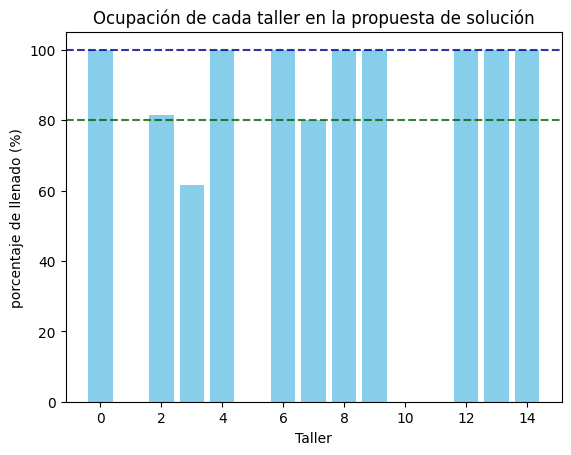

In [26]:
#contar cuanto se llenó cada taller
talleres = []
porcentajes = []
U_2 = U + U
capacidad_real_taller = defaultdict(int) #la key es el id del taller 0, 1,... y el value es la cantidad de alumnos asignados a este taller en la solución
for key, value in dic_asignaciones_realizadas.items():
    for taller in value:
       capacidad_real_taller[taller] += 1 

for taller, cantidad in sorted(capacidad_real_taller.items()):
    porcentaje = 100 * cantidad / U_2[taller]
    talleres.append(taller)
    porcentajes.append(porcentaje)
    print(f"El taller {taller} tiene {cantidad} alumnos, está un {100*(cantidad/U_2[taller])}% lleno")

plt.bar(talleres, porcentajes, color='skyblue')
plt.ylabel('porcentaje de llenado (%)')
plt.xlabel('Taller')
plt.title('Ocupación de cada taller en la propuesta de solución')
plt.axhline(100, color='darkblue', linestyle='--', linewidth=1.5, label='100%', alpha=0.8)
plt.axhline(80, color='darkgreen', linestyle='--', linewidth=1.5, label='80%', alpha=0.8)

## AAL bachelor

In [81]:
# Elegir Programa y campus
pref = pref_b_aal

# Setear Parámetros
(S, T, H, C, U, t_pref, D, p) = util.get_par(pref)

#en este caso no hay taller de 1 día
C = [4, 5]                              # capacidad de talleres por horario (AM, PM)
U = [70 for _ in range(pref.shape[1])]  # capacidad de cada taller

print("Hay", len(pref), "estudiantes, considerar esto al elegir capacidad y número de talleres")
print("\n")
pref.head()

Hay 231 estudiantes, considerar esto al elegir capacidad y número de talleres




,Digitale praksisser i projektarbejdet,Etisk teknologivurdering,Facilitering af produktive møder,Generativ AI i studiepraksis,"Motivation, trivsel og work-life balance",Psykologisk tryghed i teams,SCRUM-teknikker i projektarbejdet,Samarbejde på tværs af fagligheder,Systemtænkning i ingeniørvidenskab,Tværfagligt problemdesign
17,NaN,3.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN
18,NaN,3.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN
35,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,1.0,NaN
36,3.0,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN
47,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,2.0,NaN


In [82]:
print(f'Usando pesos: {p}')

Usando pesos: [10, 5, 3]


In [83]:
%%time
# 0 al final para que no hable tanto, 1 si quiero más infor
#modelo, y, z, w = solver(S, T, H, C, U, t_pref, D, p, 0)
modelo_b_AAL, y, z, w = Solver_V3.solver(S, T, H, C, U, t_pref, D, p, 1) 

Set parameter TimeLimit to value 1800
Set parameter OutputFlag to value 1
Set parameter Seed to value 69420
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  1800
Seed  69420

Optimize a model with 7434 rows, 4680 columns and 27840 nonzeros
Model fingerprint: 0x191e379d
Model has 462 quadratic constraints
Variable types: 0 continuous, 4680 integer (4680 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
  QRHS range       [1e+00, 1e+00]
Presolve removed 231 rows and 0 columns
Presolve time: 0.12s
Presolved: 16905 rows, 13920 columns, 60180 nonzeros
Variable types: 0 continuous, 13920 integer (13920

## Resultados AAL bachelor

In [84]:
#restricciones y variables
print(f"{modelo_b_AAL.NumConstrs} son restricciones lineales")
print(f"{modelo_b_AAL.NumQConstrs} son restricciones cuadraticas")
print(f"{modelo_b_AAL.NumGenConstrs} son restricciones generales")
print(f"{modelo_b_AAL.NumVars} variables")

7434 son restricciones lineales
462 son restricciones cuadraticas
0 son restricciones generales
4680 variables


In [85]:
# En promedio, puntaje por alumno
modelo_b_AAL.ObjVal / (len(S) - 1)

13.860869565217392

In [86]:
#Talleres: se realizan o no
util.ver_talleres(z)

El taller 0 no se realizará
El taller 1 no se realizará
El taller 2 fue elegido para realizarse
El taller 3 no se realizará
El taller 4 no se realizará
El taller 5 no se realizará
El taller 6 fue elegido para realizarse
El taller 7 no se realizará
El taller 8 fue elegido para realizarse
El taller 9 no se realizará
El taller 10 no se realizará
El taller 11 no se realizará
El taller 12 no se realizará
El taller 13 fue elegido para realizarse
El taller 14 fue elegido para realizarse
El taller 15 fue elegido para realizarse
El taller 16 no se realizará
El taller 17 fue elegido para realizarse
El taller 18 fue elegido para realizarse
El taller 19 fue elegido para realizarse


In [87]:
#Para ver la versión del taller que se realiza, ya que los talleres se pueden dar más de una vez
util.ver_talleres_mod(z, len(T))

El taller 0.0 no se realizará
El taller 1.0 no se realizará
El taller 2.0 fue elegido para realizarse
El taller 3.0 no se realizará
El taller 4.0 no se realizará
El taller 5.0 no se realizará
El taller 6.0 fue elegido para realizarse
El taller 7.0 no se realizará
El taller 8.0 fue elegido para realizarse
El taller 9.0 no se realizará
El taller 0.1 no se realizará
El taller 1.1 no se realizará
El taller 2.1 no se realizará
El taller 3.1 fue elegido para realizarse
El taller 4.1 fue elegido para realizarse
El taller 5.1 fue elegido para realizarse
El taller 6.1 no se realizará
El taller 7.1 fue elegido para realizarse
El taller 8.1 fue elegido para realizarse
El taller 9.1 fue elegido para realizarse


In [88]:
#horario de cada taller
talleres_AM, talleres_PM = util.talleres_horarios(y)

El taller 2 se da en el horario AM
El taller 6 se da en el horario PM
El taller 8 se da en el horario AM
El taller 13 se da en el horario AM
El taller 14 se da en el horario PM
El taller 15 se da en el horario PM
El taller 17 se da en el horario AM
El taller 18 se da en el horario PM
El taller 19 se da en el horario PM


In [89]:
#Talleres y sus bloques horarios
print("Talleres AM")
for i in talleres_AM:
    print("- Taller " + str(i))

print("Talleres PM")
for i in talleres_PM:
    print("- Taller " + str(i))

Talleres AM
- Taller 2
- Taller 8
- Taller 13
- Taller 17
Talleres PM
- Taller 6
- Taller 14
- Taller 15
- Taller 18
- Taller 19


In [90]:
#Talleres y sus bloques horarios, considerando la versión del taller
print("Talleres AM")
for i in talleres_AM:
    print("- Taller " + str(i%(len(T))) + "." + str(i//(len(T))))

print("Talleres PM")
for i in talleres_PM:
    print("- Taller " + str(i%(len(T))) + "." + str(i//(len(T))))

Talleres AM
- Taller 2.0
- Taller 8.0
- Taller 3.1
- Taller 7.1
Talleres PM
- Taller 6.0
- Taller 4.1
- Taller 5.1
- Taller 8.1
- Taller 9.1


In [91]:
#Asignaciones de estudiantes a los talleres
dic_asignaciones_realizadas = util.ver_asignaciones(w)

El estudiante 0 fue asignado al taller 13
El estudiante 0 fue asignado al taller 18
El estudiante 1 fue asignado al taller 13
El estudiante 1 fue asignado al taller 18
El estudiante 2 fue asignado al taller 8
El estudiante 2 fue asignado al taller 14
El estudiante 3 fue asignado al taller 2
El estudiante 3 fue asignado al taller 14
El estudiante 4 fue asignado al taller 8
El estudiante 4 fue asignado al taller 14
El estudiante 5 fue asignado al taller 8
El estudiante 5 fue asignado al taller 14
El estudiante 6 fue asignado al taller 8
El estudiante 6 fue asignado al taller 14
El estudiante 7 fue asignado al taller 8
El estudiante 7 fue asignado al taller 19
El estudiante 8 fue asignado al taller 13
El estudiante 8 fue asignado al taller 19
El estudiante 9 fue asignado al taller 8
El estudiante 9 fue asignado al taller 19
El estudiante 10 fue asignado al taller 8
El estudiante 10 fue asignado al taller 19
El estudiante 11 fue asignado al taller 8
El estudiante 11 fue asignado al taller 

In [92]:
#este diccionario es importante pues indica a la versión del taller al que fue asignado (v1 o v2, y con esto se ve el horario)
print(dic_asignaciones_realizadas) #key: estudiante, value:[talleres asignados]

{0: [13, 18], 1: [13, 18], 2: [8, 14], 3: [2, 14], 4: [8, 14], 5: [8, 14], 6: [8, 14], 7: [8, 19], 8: [13, 19], 9: [8, 19], 10: [8, 19], 11: [8, 19], 12: [8, 19], 13: [13, 18], 14: [8, 19], 15: [2, 19], 16: [13, 15], 17: [13, 15], 18: [17, 19], 19: [2, 18], 20: [17, 18], 21: [13, 14], 22: [8, 19], 23: [17, 19], 24: [17, 18], 25: [2, 15], 26: [8, 19], 27: [2, 14], 28: [8, 19], 29: [6, 13], 30: [6, 13], 31: [17, 18], 32: [15, 17], 33: [13, 18], 34: [13, 18], 35: [13, 15], 36: [17, 18], 37: [2, 14], 38: [8, 19], 39: [8, 14], 40: [15, 17], 41: [8, 19], 42: [8, 14], 43: [2, 18], 44: [13, 18], 45: [2, 6], 46: [8, 14], 47: [17, 18], 48: [6, 13], 49: [6, 8], 50: [6, 8], 51: [2, 6], 52: [13, 14], 53: [13, 14], 54: [13, 18], 55: [13, 14], 56: [13, 18], 57: [8, 19], 58: [8, 19], 59: [8, 19], 60: [13, 18], 61: [13, 18], 62: [13, 18], 63: [13, 18], 64: [2, 18], 65: [17, 18], 66: [14, 17], 67: [2, 6], 68: [8, 19], 69: [13, 15], 70: [8, 19], 71: [8, 14], 72: [8, 14], 73: [8, 14], 74: [13, 14], 75: [8

In [93]:
#crea el mismo diccionario de antes, pero sin importar a la versión a la que fue asignado el estudiante, solo al taller
n_talleres = len(T)
dic_asignaciones_realizadas_mod = {k: [x%n_talleres for x in v] for k, v in dic_asignaciones_realizadas.items()}

In [94]:
#Todos deben ser iguales, es decir, todos los estudiantes fueron asignados a talleres
print(len(S), len(dic_asignaciones_realizadas), len(dic_asignaciones_realizadas_mod))

231 231 231


## Estadísticas AAL bachelor

In [95]:
#este sí considera dobles versiones para contabilizar
contador_primera_opt = 0 #quedó en top 1 y la otra no quería
contador_segunda_opt = 0 #quedó en top 2 y la otra no quería
contador_tercera_opt = 0 #quedó en top 3 y la otra no quería
contador_primera_segunda_opt = 0 #quedó en top 1 y top2
contador_segunda_tercera_opt = 0 #quedó en top 2 y top 3
contador_primera_tercera_opt = 0 #quedó en top 1 y top 3
contador_ninguna = 0 #no quedó en ninguna que quería
contador_primera_opt_whole_day = 0 #quedó en top 1 y era taller de solo un día
contador_segunda_opt_whole_day = 0 #quedó en top 2 y era taller de solo un día
contador_tercera_opt_whole_day = 0 #quedó en top 3 y era taller de solo un día

for s in range(len(S)):
    if (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]):
        contador_primera_segunda_opt += 1 #quedó en top 1 y top2
    elif (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]):
        contador_segunda_tercera_opt += 1 #quedó en top 2 y top 3
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]):
        contador_primera_tercera_opt += 1 #quedó en top 1 y top 3
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_primera_opt += 1 #quedó en top 1 y la otra no quería
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_segunda_opt += 1 #quedó en top 2 y la otra no quería
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_tercera_opt += 1 #quedó en top 3 y la otra no quería
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_primera_opt_whole_day += 1 #quedó en top 1 y era todo el dia
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_segunda_opt_whole_day += 1 #quedó en top 2 y era todo el dia
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_tercera_opt_whole_day += 1 #quedó en top 3 y era todo el dia
    else:
        contador_ninguna += 1 #no quedó en ninguna que quería
        print(dic_asignaciones_realizadas_mod[s])
        print(t_pref[s])

n_alumnos = len(t_pref)

print(f"Hay {contador_primera_opt} solo en su primera opción, un {100*contador_primera_opt/n_alumnos}%")
print(f"Hay {contador_segunda_opt} solo en su segunda opción, un {100*contador_segunda_opt/n_alumnos}%")
print(f"Hay {contador_tercera_opt} solo en su tercera opción, un {100*contador_tercera_opt/n_alumnos}%")
print(f"Hay {contador_primera_segunda_opt} en su primera y segunda opción, un {100*contador_primera_segunda_opt/n_alumnos}%")
print(f"Hay {contador_segunda_tercera_opt} en su segunda y tercera opción, un {100*contador_segunda_tercera_opt/n_alumnos}%")
print(f"Hay {contador_primera_tercera_opt} en su primera y tercera opción, un {100*contador_primera_tercera_opt/n_alumnos}%")
print(f"Hay {contador_ninguna} en nada que eligió :(, un {100*contador_ninguna/n_alumnos}%")
print(f"Hay {contador_primera_opt_whole_day} solo en su primera opcion, pero esta era de día completo, un {100*contador_primera_opt_whole_day/n_alumnos}%")
print(f"Hay {contador_segunda_opt_whole_day} solo en su segunda opción, pero esta era de día completo, un {100*contador_segunda_opt_whole_day/n_alumnos}%")
print(f"Hay {contador_tercera_opt_whole_day} solo en su tercera opción, pero esta era de día completo, un {100*contador_tercera_opt_whole_day/n_alumnos}%")

print("En total hay:", contador_primera_opt + contador_segunda_opt + contador_tercera_opt + contador_primera_segunda_opt + contador_segunda_tercera_opt + contador_primera_tercera_opt + contador_ninguna + contador_primera_opt_whole_day + contador_segunda_opt_whole_day + contador_tercera_opt_whole_day, "estudiantes")

Hay 12 solo en su primera opción, un 5.194805194805195%
Hay 2 solo en su segunda opción, un 0.8658008658008658%
Hay 1 solo en su tercera opción, un 0.4329004329004329%
Hay 156 en su primera y segunda opción, un 67.53246753246754%
Hay 13 en su segunda y tercera opción, un 5.627705627705628%
Hay 47 en su primera y tercera opción, un 20.346320346320347%
Hay 0 en nada que eligió :(, un 0.0%
Hay 0 solo en su primera opcion, pero esta era de día completo, un 0.0%
Hay 0 solo en su segunda opción, pero esta era de día completo, un 0.0%
Hay 0 solo en su tercera opción, pero esta era de día completo, un 0.0%
En total hay: 231 estudiantes


In [96]:
contador_primera = 0
contador_segunda = 0
for s in range(len(S)):
    if (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]):
        contador_primera += 1 #quedó en top 1
    if (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]):
        contador_segunda += 1 #quedó en top2
print("En 1era opcion", contador_primera)
print("En 2nda opcion", contador_segunda)

En 1era opcion 215
En 2nda opcion 171


In [97]:
#contar cuantos quedaron solo en lo que pidieron, es decir todos los talleres a los que fueron asignados, estaban en su lista
contador_suertudo = 0
contador_no = 0
contador = 0

for s in range(len(S)):
    asignados = dic_asignaciones_realizadas_mod[s]  
    prefs_vals = set(t_pref[s].values())     

    #todos los asignados están entre los valores preferidos
    if all(a in prefs_vals for a in asignados):
        contador_suertudo += 1
    else:
        contador_no += 1
        print(s, prefs_vals, asignados)
    contador += 1
print("\n")
print("Total suertudos:", contador_suertudo, contador_suertudo/n_alumnos)
print(f"Hay {contador_no} estudiantes que quedaron en algo que no pidieron (al menos 1 taller), esto es el {contador_no/n_alumnos} de 1")

3 {0, 4, 6} [2, 4]
15 {0, 2, 3} [2, 9]
37 {9, 4, 6} [2, 4]
68 {0, 1, 8} [8, 9]
106 {1, 4, 5} [2, 5]
107 {1, 4, 5} [2, 5]
108 {1, 4, 5} [2, 5]
109 {0, 5, 6} [2, 5]
121 {0, 9, 6} [6, 7]
142 {9, 4, 6} [2, 4]
145 {8, 1, 0} [8, 9]
164 {1, 4, 5} [5, 7]
198 {1, 5, 9} [2, 5]
222 {0, 1, 4} [2, 4]
230 {0, 1, 9} [2, 9]


Total suertudos: 216 0.935064935064935
Hay 15 estudiantes que quedaron en algo que no pidieron (al menos 1 taller), esto es el 0.06493506493506493 de 1


El taller 2 tiene 45 alumnos, está un 64.28571428571429% lleno
El taller 6 tiene 24 alumnos, está un 34.285714285714285% lleno
El taller 8 tiene 66 alumnos, está un 94.28571428571428% lleno
El taller 13 tiene 70 alumnos, está un 100.0% lleno
El taller 14 tiene 69 alumnos, está un 98.57142857142858% lleno
El taller 15 tiene 23 alumnos, está un 32.857142857142854% lleno
El taller 17 tiene 50 alumnos, está un 71.42857142857143% lleno
El taller 18 tiene 61 alumnos, está un 87.14285714285714% lleno
El taller 19 tiene 54 alumnos, está un 77.14285714285715% lleno


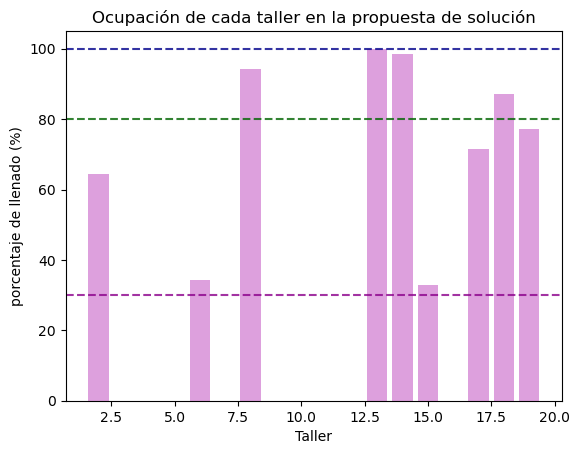

In [100]:
#contar cuanto se llenó cada taller
talleres = []
porcentajes = []
U_2 = U + U
capacidad_real_taller = defaultdict(int) #la key es el id del taller 0, 1,... y el value es la cantidad de alumnos asignados a este taller en la solución
for key, value in dic_asignaciones_realizadas.items():
    for taller in value:
       capacidad_real_taller[taller] += 1 

for taller, cantidad in sorted(capacidad_real_taller.items()):
    porcentaje = 100 * cantidad / U_2[taller]
    talleres.append(taller)
    porcentajes.append(porcentaje)
    print(f"El taller {taller} tiene {cantidad} alumnos, está un {100*(cantidad/U_2[taller])}% lleno")

plt.bar(talleres, porcentajes, color='plum')
plt.ylabel('porcentaje de llenado (%)')
plt.xlabel('Taller')
plt.title('Ocupación de cada taller en la propuesta de solución')
plt.axhline(100, color='darkblue', linestyle='--', linewidth=1.5, label='100%', alpha=0.8)
plt.axhline(80, color='darkgreen', linestyle='--', linewidth=1.5, label='80%', alpha=0.8)
plt.axhline(30, color='darkmagenta', linestyle='--', linewidth=1.5, label='80%', alpha=0.8)

## CPH magister

In [103]:
# Elegir Programa y campus
pref = pref_m_cph

# Setear Parámetros
(S, T, H, C, U, t_pref, D, p) = util.get_par(pref)

D[1] = 1                                # el taller 1 es de día completo
C = [2, 2]                              # capacidad de talleres por horario (AM, PM)
U = [50 for _ in range(pref.shape[1])]  # capacidad de cada taller (todos con 80 cupos)

print("Hay", len(pref), "estudiantes, considerar esto al elegir capacidad y número de talleres")

pref.head()

Hay 60 estudiantes, considerar esto al elegir capacidad y número de talleres


,Clarification of individual professional competences,Creative and systems thinking for complex problem-solving (whole day workshop - you are then attending 1 workshop the whole day),Digital and hybrid practices in collaborative work,Ethical technology assessment,Leadership and project management,Professional communication with external partners,Professional identity development,Psychological safety in team work
45,3.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0
55,1.0,NaN,NaN,NaN,3.0,NaN,2.0,NaN
63,NaN,2.0,3.0,1.0,NaN,NaN,NaN,NaN
64,NaN,NaN,NaN,2.0,NaN,3.0,1.0,NaN
65,NaN,2.0,NaN,NaN,1.0,3.0,NaN,NaN


In [104]:
#p = [8, 4, 2] #por si quiero modificar los pesos estándar [10, 5, 3]
print(f'Usando pesos: {p}')

Usando pesos: [10, 5, 3]


In [105]:
%%time
# 0 al final para que no hable tanto, 1 si quiero más infor
#modelo, y, z, w = solver(S, T, H, C, U, t_pref, D, p, 0)
modelo_m_CPH, y, z, w = Solver_V3.solver(S, T, H, C, U, t_pref, D, p, 1) 

Set parameter TimeLimit to value 1800
Set parameter OutputFlag to value 1
Set parameter Seed to value 69420
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  1800
Seed  69420

Optimize a model with 1594 rows, 1008 columns and 5856 nonzeros
Model fingerprint: 0x3078b055
Model has 120 quadratic constraints
Variable types: 0 continuous, 1008 integer (1008 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
  QRHS range       [1e+00, 1e+00]
Presolve removed 122 rows and 4 columns
Presolve time: 0.02s
Presolved: 3272 rows, 2684 columns, 12330 nonzeros
Variable types: 0 continuous, 2684 integer (2684 bina

## Resultados CPH magister

In [106]:
#restricciones y variables
print(f"{modelo_m_CPH.NumConstrs} son restricciones lineales")
print(f"{modelo_m_CPH.NumQConstrs} son restricciones cuadraticas")
print(f"{modelo_m_CPH.NumGenConstrs} son restricciones generales")
print(f"{modelo_m_CPH.NumVars} variables")

1594 son restricciones lineales
120 son restricciones cuadraticas
0 son restricciones generales
1008 variables


In [107]:
# En promedio, puntaje por alumno
modelo_m_CPH.ObjVal / (len(S) - 1)

10.915254237288135

In [108]:
#Talleres: se realizan o no
util.ver_talleres(z)

El taller 0 no se realizará
El taller 1 no se realizará
El taller 2 no se realizará
El taller 3 fue elegido para realizarse
El taller 4 no se realizará
El taller 5 no se realizará
El taller 6 fue elegido para realizarse
El taller 7 no se realizará
El taller 8 fue elegido para realizarse
El taller 9 no se realizará
El taller 10 no se realizará
El taller 11 no se realizará
El taller 12 fue elegido para realizarse
El taller 13 no se realizará
El taller 14 no se realizará
El taller 15 no se realizará


In [109]:
#Para ver la versión del taller que se realiza, ya que los talleres se pueden dar más de una vez
util.ver_talleres_mod(z, len(T))

El taller 0.0 no se realizará
El taller 1.0 no se realizará
El taller 2.0 no se realizará
El taller 3.0 fue elegido para realizarse
El taller 4.0 no se realizará
El taller 5.0 no se realizará
El taller 6.0 fue elegido para realizarse
El taller 7.0 no se realizará
El taller 0.1 fue elegido para realizarse
El taller 1.1 no se realizará
El taller 2.1 no se realizará
El taller 3.1 no se realizará
El taller 4.1 fue elegido para realizarse
El taller 5.1 no se realizará
El taller 6.1 no se realizará
El taller 7.1 no se realizará


In [110]:
#horario de cada taller
talleres_AM, talleres_PM = util.talleres_horarios(y)

El taller 3 se da en el horario AM
El taller 6 se da en el horario AM
El taller 8 se da en el horario PM
El taller 12 se da en el horario PM


In [111]:
#Talleres y sus bloques horarios
print("Talleres AM")
for i in talleres_AM:
    print("- Taller " + str(i))

print("Talleres PM")
for i in talleres_PM:
    print("- Taller " + str(i))

Talleres AM
- Taller 3
- Taller 6
Talleres PM
- Taller 8
- Taller 12


In [112]:
#Talleres y sus bloques horarios, considerando la versión del taller
print("Talleres AM")
for i in talleres_AM:
    print("- Taller " + str(i%(len(T))) + "." + str(i//(len(T))))

print("Talleres PM")
for i in talleres_PM:
    print("- Taller " + str(i%(len(T))) + "." + str(i//(len(T))))

Talleres AM
- Taller 3.0
- Taller 6.0
Talleres PM
- Taller 0.1
- Taller 4.1


In [113]:
#Asignaciones de estudiantes a los talleres
dic_asignaciones_realizadas = util.ver_asignaciones(w)

El estudiante 0 fue asignado al taller 6
El estudiante 0 fue asignado al taller 8
El estudiante 1 fue asignado al taller 6
El estudiante 1 fue asignado al taller 8
El estudiante 2 fue asignado al taller 3
El estudiante 2 fue asignado al taller 12
El estudiante 3 fue asignado al taller 6
El estudiante 3 fue asignado al taller 12
El estudiante 4 fue asignado al taller 6
El estudiante 4 fue asignado al taller 12
El estudiante 5 fue asignado al taller 6
El estudiante 5 fue asignado al taller 8
El estudiante 6 fue asignado al taller 3
El estudiante 6 fue asignado al taller 12
El estudiante 7 fue asignado al taller 3
El estudiante 7 fue asignado al taller 12
El estudiante 8 fue asignado al taller 6
El estudiante 8 fue asignado al taller 8
El estudiante 9 fue asignado al taller 6
El estudiante 9 fue asignado al taller 12
El estudiante 10 fue asignado al taller 3
El estudiante 10 fue asignado al taller 12
El estudiante 11 fue asignado al taller 6
El estudiante 11 fue asignado al taller 12
El e

In [114]:
#este diccionario es importante pues indica a la versión del taller al que fue asignado (v1 o v2, y con esto se ve el horario)
print(dic_asignaciones_realizadas) #key: estudiante, value:[talleres asignados]

{0: [6, 8], 1: [6, 8], 2: [3, 12], 3: [6, 12], 4: [6, 12], 5: [6, 8], 6: [3, 12], 7: [3, 12], 8: [6, 8], 9: [6, 12], 10: [3, 12], 11: [6, 12], 12: [6, 8], 13: [6, 12], 14: [3, 12], 15: [6, 12], 16: [3, 8], 17: [3, 12], 18: [3, 12], 19: [6, 12], 20: [6, 8], 21: [6, 12], 22: [3, 8], 23: [3, 8], 24: [3, 8], 25: [3, 12], 26: [6, 8], 27: [3, 12], 28: [6, 8], 29: [6, 8], 30: [3, 8], 31: [6, 8], 32: [6, 12], 33: [6, 12], 34: [6, 8], 35: [6, 12], 36: [6, 12], 37: [6, 12], 38: [3, 12], 39: [6, 12], 40: [6, 8], 41: [3, 12], 42: [3, 8], 43: [6, 8], 44: [6, 8], 45: [3, 12], 46: [6, 8], 47: [6, 8], 48: [6, 12], 49: [6, 8], 50: [3, 8], 51: [6, 8], 52: [6, 12], 53: [6, 12], 54: [3, 12], 55: [6, 12], 56: [6, 12], 57: [6, 8], 58: [6, 8], 59: [6, 12]}


In [115]:
#crea el mismo diccionario de antes, pero sin importar a la versión a la que fue asignado el estudiante, solo al taller
n_talleres = len(T)
dic_asignaciones_realizadas_mod = {k: [x%n_talleres for x in v] for k, v in dic_asignaciones_realizadas.items()}

In [116]:
#Todos deben ser iguales, es decir, todos los estudiantes fueron asignados a talleres
print(len(S), len(dic_asignaciones_realizadas), len(dic_asignaciones_realizadas_mod))

60 60 60


## Estadísticas CPH magister

In [117]:
#este sí considera dobles versiones para contabilizar
contador_primera_opt = 0 #quedó en top 1 y la otra no quería
contador_segunda_opt = 0 #quedó en top 2 y la otra no quería
contador_tercera_opt = 0 #quedó en top 3 y la otra no quería
contador_primera_segunda_opt = 0 #quedó en top 1 y top2
contador_segunda_tercera_opt = 0 #quedó en top 2 y top 3
contador_primera_tercera_opt = 0 #quedó en top 1 y top 3
contador_ninguna = 0 #no quedó en ninguna que quería
contador_primera_opt_whole_day = 0 #quedó en top 1 y era taller de solo un día
contador_segunda_opt_whole_day = 0 #quedó en top 2 y era taller de solo un día
contador_tercera_opt_whole_day = 0 #quedó en top 3 y era taller de solo un día

for s in range(len(S)):
    if (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]):
        contador_primera_segunda_opt += 1 #quedó en top 1 y top2
    elif (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]):
        contador_segunda_tercera_opt += 1 #quedó en top 2 y top 3
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]):
        contador_primera_tercera_opt += 1 #quedó en top 1 y top 3
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_primera_opt += 1 #quedó en top 1 y la otra no quería
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_segunda_opt += 1 #quedó en top 2 y la otra no quería
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_tercera_opt += 1 #quedó en top 3 y la otra no quería
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_primera_opt_whole_day += 1 #quedó en top 1 y era todo el dia
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_segunda_opt_whole_day += 1 #quedó en top 2 y era todo el dia
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_tercera_opt_whole_day += 1 #quedó en top 3 y era todo el dia
    else:
        contador_ninguna += 1 #no quedó en ninguna que quería
        print(dic_asignaciones_realizadas_mod[s])
        print(t_pref[s])

n_alumnos = len(t_pref)

print(f"Hay {contador_primera_opt} solo en su primera opción, un {100*contador_primera_opt/n_alumnos}%")
print(f"Hay {contador_segunda_opt} solo en su segunda opción, un {100*contador_segunda_opt/n_alumnos}%")
print(f"Hay {contador_tercera_opt} solo en su tercera opción, un {100*contador_tercera_opt/n_alumnos}%")
print(f"Hay {contador_primera_segunda_opt} en su primera y segunda opción, un {100*contador_primera_segunda_opt/n_alumnos}%")
print(f"Hay {contador_segunda_tercera_opt} en su segunda y tercera opción, un {100*contador_segunda_tercera_opt/n_alumnos}%")
print(f"Hay {contador_primera_tercera_opt} en su primera y tercera opción, un {100*contador_primera_tercera_opt/n_alumnos}%")
print(f"Hay {contador_ninguna} en nada que eligió :(, un {100*contador_ninguna/n_alumnos}%")
print(f"Hay {contador_primera_opt_whole_day} solo en su primera opcion, pero esta era de día completo, un {100*contador_primera_opt_whole_day/n_alumnos}%")
print(f"Hay {contador_segunda_opt_whole_day} solo en su segunda opción, pero esta era de día completo, un {100*contador_segunda_opt_whole_day/n_alumnos}%")
print(f"Hay {contador_tercera_opt_whole_day} solo en su tercera opción, pero esta era de día completo, un {100*contador_tercera_opt_whole_day/n_alumnos}%")

print("En total hay:", contador_primera_opt + contador_segunda_opt + contador_tercera_opt + contador_primera_segunda_opt + contador_segunda_tercera_opt + contador_primera_tercera_opt + contador_ninguna + contador_primera_opt_whole_day + contador_segunda_opt_whole_day + contador_tercera_opt_whole_day, "estudiantes")

Hay 8 solo en su primera opción, un 13.333333333333334%
Hay 10 solo en su segunda opción, un 16.666666666666668%
Hay 2 solo en su tercera opción, un 3.3333333333333335%
Hay 19 en su primera y segunda opción, un 31.666666666666668%
Hay 10 en su segunda y tercera opción, un 16.666666666666668%
Hay 11 en su primera y tercera opción, un 18.333333333333332%
Hay 0 en nada que eligió :(, un 0.0%
Hay 0 solo en su primera opcion, pero esta era de día completo, un 0.0%
Hay 0 solo en su segunda opción, pero esta era de día completo, un 0.0%
Hay 0 solo en su tercera opción, pero esta era de día completo, un 0.0%
En total hay: 60 estudiantes


In [118]:
contador_primera = 0
contador_segunda = 0
for s in range(len(S)):
    if (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]):
        contador_primera += 1 #quedó en top 1
    if (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]):
        contador_segunda += 1 #quedó en top2
print("En 1era opcion", contador_primera)
print("En 2nda opcion", contador_segunda)

En 1era opcion 38
En 2nda opcion 39


In [119]:
#contar cuantos quedaron solo en lo que pidieron, es decir todos los talleres a los que fueron asignados, estaban en su lista
contador_suertudo = 0
contador_no = 0
contador = 0

for s in range(len(S)):
    asignados = dic_asignaciones_realizadas_mod[s]  
    prefs_vals = set(t_pref[s].values())     

    #todos los asignados están entre los valores preferidos
    if all(a in prefs_vals for a in asignados):
        contador_suertudo += 1
    else:
        contador_no += 1
        print(s, prefs_vals, asignados)
    contador += 1
print("\n")
print("Total suertudos:", contador_suertudo, contador_suertudo/n_alumnos)
print(f"Hay {contador_no} estudiantes que quedaron en algo que no pidieron (al menos 1 taller), esto es el {contador_no/n_alumnos} de 1")

2 {1, 2, 3} [3, 4]
3 {3, 5, 6} [6, 4]
4 {1, 4, 5} [6, 4]
6 {1, 3, 7} [3, 4]
7 {0, 4, 7} [3, 4]
10 {1, 3, 5} [3, 4]
13 {1, 4, 5} [6, 4]
14 {0, 4, 5} [3, 4]
16 {0, 2, 4} [3, 0]
18 {0, 4, 7} [3, 4]
25 {4, 5, 7} [3, 4]
29 {0, 1, 4} [6, 0]
34 {1, 2, 6} [6, 0]
37 {1, 5, 6} [6, 4]
39 {1, 4, 7} [6, 4]
41 {1, 2, 3} [3, 4]
48 {1, 6, 7} [6, 4]
52 {1, 4, 7} [6, 4]
53 {1, 4, 5} [6, 4]
54 {1, 4, 5} [3, 4]


Total suertudos: 40 0.6666666666666666
Hay 20 estudiantes que quedaron en algo que no pidieron (al menos 1 taller), esto es el 0.3333333333333333 de 1


El taller 3 tiene 20 alumnos, está un 40.0% lleno
El taller 6 tiene 40 alumnos, está un 80.0% lleno
El taller 8 tiene 27 alumnos, está un 54.0% lleno
El taller 12 tiene 33 alumnos, está un 66.0% lleno


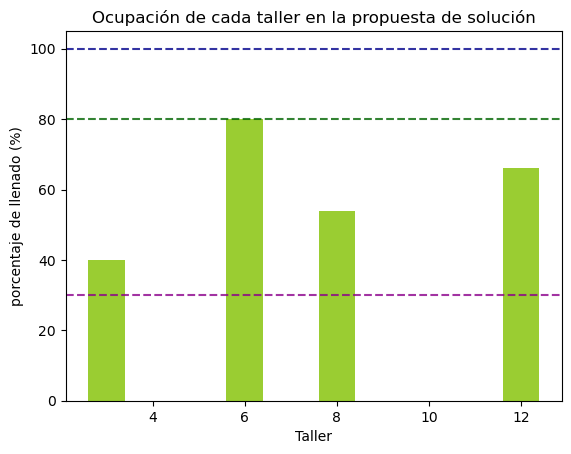

In [121]:
#contar cuanto se llenó cada taller
talleres = []
porcentajes = []
U_2 = U + U
capacidad_real_taller = defaultdict(int) #la key es el id del taller 0, 1,... y el value es la cantidad de alumnos asignados a este taller en la solución
for key, value in dic_asignaciones_realizadas.items():
    for taller in value:
       capacidad_real_taller[taller] += 1 

for taller, cantidad in sorted(capacidad_real_taller.items()):
    porcentaje = 100 * cantidad / U_2[taller]
    talleres.append(taller)
    porcentajes.append(porcentaje)
    print(f"El taller {taller} tiene {cantidad} alumnos, está un {100*(cantidad/U_2[taller])}% lleno")

plt.bar(talleres, porcentajes, color='yellowgreen')
plt.ylabel('porcentaje de llenado (%)')
plt.xlabel('Taller')
plt.title('Ocupación de cada taller en la propuesta de solución')
plt.axhline(100, color='darkblue', linestyle='--', linewidth=1.5, label='100%', alpha=0.8)
plt.axhline(80, color='darkgreen', linestyle='--', linewidth=1.5, label='80%', alpha=0.8)
plt.axhline(30, color='darkmagenta', linestyle='--', linewidth=1.5, label='80%', alpha=0.8)

## CPH bachelor

In [170]:
# Elegir Programa y campus
pref = pref_b_cph

# Setear Parámetros
(S, T, H, C, U, t_pref, D, p) = util.get_par(pref)

#en este caso no hay taller de 1 día
C = [2, 3]                              # capacidad de talleres por horario (AM, PM)
U = [50 for _ in range(pref.shape[1])]  # capacidad de cada taller

print("Hay", len(pref), "estudiantes, considerar esto al elegir capacidad y número de talleres")
print("\n")
pref.head()

Hay 57 estudiantes, considerar esto al elegir capacidad y número de talleres




,Digitale praksisser i projektarbejdet,Etisk teknologivurdering,Facilitering af produktive møder,Generativ AI i studiepraksis,"Motivation, trivsel og work-life balance",Psykologisk tryghed i teams,SCRUM-teknikker i projektarbejdet,Samarbejde på tværs af fagligheder,Systemtænkning i ingeniørvidenskab,Tværfagligt problemdesign
69,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,2.0,NaN
70,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,2.0,NaN
71,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,2.0,NaN
76,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,3.0
113,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,2.0,NaN


In [171]:
#p = [16, 15, 2]
print(f'Usando pesos: {p}')

Usando pesos: [10, 5, 3]


In [172]:
%%time
# 0 al final para que no hable tanto, 1 si quiero más infor
#modelo, y, z, w = solver(S, T, H, C, U, t_pref, D, p, 0)
modelo_b_CPH, y, z, w = Solver_V3.solver(S, T, H, C, U, t_pref, D, p, 1) 

Set parameter TimeLimit to value 1800
Set parameter OutputFlag to value 1
Set parameter Seed to value 69420
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  1800
Seed  69420

Optimize a model with 1866 rows, 1200 columns and 6960 nonzeros
Model fingerprint: 0x7deda033
Model has 114 quadratic constraints
Variable types: 0 continuous, 1200 integer (1200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
  QRHS range       [1e+00, 1e+00]
Presolve removed 57 rows and 0 columns
Presolve time: 0.03s
Presolved: 4203 rows, 3480 columns, 14940 nonzeros
Variable types: 0 continuous, 3480 integer (3480 binar

## Resultados CPH bachelor

In [173]:
#restricciones y variables
print(f"{modelo_b_CPH.NumConstrs} son restricciones lineales")
print(f"{modelo_b_CPH.NumQConstrs} son restricciones cuadraticas")
print(f"{modelo_b_CPH.NumGenConstrs} son restricciones generales")
print(f"{modelo_b_CPH.NumVars} variables")

1866 son restricciones lineales
114 son restricciones cuadraticas
0 son restricciones generales
1200 variables


In [174]:
# En promedio, puntaje por alumno
modelo_b_CPH.ObjVal / (len(S) - 1)

11.017857142857142

In [175]:
#Talleres: se realizan o no
util.ver_talleres(z)

El taller 0 no se realizará
El taller 1 no se realizará
El taller 2 no se realizará
El taller 3 no se realizará
El taller 4 no se realizará
El taller 5 no se realizará
El taller 6 fue elegido para realizarse
El taller 7 no se realizará
El taller 8 fue elegido para realizarse
El taller 9 no se realizará
El taller 10 no se realizará
El taller 11 no se realizará
El taller 12 fue elegido para realizarse
El taller 13 fue elegido para realizarse
El taller 14 no se realizará
El taller 15 fue elegido para realizarse
El taller 16 no se realizará
El taller 17 no se realizará
El taller 18 no se realizará
El taller 19 no se realizará


In [176]:
#Para ver la versión del taller que se realiza, ya que los talleres se pueden dar más de una vez
util.ver_talleres_mod(z, len(T))

El taller 0.0 no se realizará
El taller 1.0 no se realizará
El taller 2.0 no se realizará
El taller 3.0 no se realizará
El taller 4.0 no se realizará
El taller 5.0 no se realizará
El taller 6.0 fue elegido para realizarse
El taller 7.0 no se realizará
El taller 8.0 fue elegido para realizarse
El taller 9.0 no se realizará
El taller 0.1 no se realizará
El taller 1.1 no se realizará
El taller 2.1 fue elegido para realizarse
El taller 3.1 fue elegido para realizarse
El taller 4.1 no se realizará
El taller 5.1 fue elegido para realizarse
El taller 6.1 no se realizará
El taller 7.1 no se realizará
El taller 8.1 no se realizará
El taller 9.1 no se realizará


In [177]:
#horario de cada taller
talleres_AM, talleres_PM = util.talleres_horarios(y)

El taller 6 se da en el horario PM
El taller 8 se da en el horario AM
El taller 12 se da en el horario AM
El taller 13 se da en el horario PM
El taller 15 se da en el horario PM


In [178]:
#Talleres y sus bloques horarios
print("Talleres AM")
for i in talleres_AM:
    print("- Taller " + str(i))

print("Talleres PM")
for i in talleres_PM:
    print("- Taller " + str(i))
    

Talleres AM
- Taller 8
- Taller 12
Talleres PM
- Taller 6
- Taller 13
- Taller 15


In [179]:
#Talleres y sus bloques horarios, considerando la versión del taller
print("Talleres AM")
for i in talleres_AM:
    print("- Taller " + str(i%(len(T))) + "." + str(i//(len(T))))

print("Talleres PM")
for i in talleres_PM:
    print("- Taller " + str(i%(len(T))) + "." + str(i//(len(T))))

Talleres AM
- Taller 8.0
- Taller 2.1
Talleres PM
- Taller 6.0
- Taller 3.1
- Taller 5.1


In [180]:
#Asignaciones de estudiantes a los talleres
dic_asignaciones_realizadas = util.ver_asignaciones(w)

El estudiante 0 fue asignado al taller 6
El estudiante 0 fue asignado al taller 8
El estudiante 1 fue asignado al taller 6
El estudiante 1 fue asignado al taller 8
El estudiante 2 fue asignado al taller 6
El estudiante 2 fue asignado al taller 8
El estudiante 3 fue asignado al taller 6
El estudiante 3 fue asignado al taller 8
El estudiante 4 fue asignado al taller 6
El estudiante 4 fue asignado al taller 8
El estudiante 5 fue asignado al taller 12
El estudiante 5 fue asignado al taller 13
El estudiante 6 fue asignado al taller 8
El estudiante 6 fue asignado al taller 13
El estudiante 7 fue asignado al taller 12
El estudiante 7 fue asignado al taller 13
El estudiante 8 fue asignado al taller 8
El estudiante 8 fue asignado al taller 13
El estudiante 9 fue asignado al taller 12
El estudiante 9 fue asignado al taller 15
El estudiante 10 fue asignado al taller 6
El estudiante 10 fue asignado al taller 8
El estudiante 11 fue asignado al taller 8
El estudiante 11 fue asignado al taller 13
El 

In [181]:
#crea el mismo diccionario de antes, pero sin importar a la versión a la que fue asignado el estudiante, solo al taller
n_talleres = len(T)
dic_asignaciones_realizadas_mod = {k: [x%n_talleres for x in v] for k, v in dic_asignaciones_realizadas.items()}

In [182]:
#Todos deben ser iguales, es decir, todos los estudiantes fueron asignados a talleres
print(len(S), len(dic_asignaciones_realizadas), len(dic_asignaciones_realizadas_mod))

57 57 57


## Estadísticas CPH bachelor

In [183]:
#este sí considera dobles versiones para contabilizar
contador_primera_opt = 0 #quedó en top 1 y la otra no quería
contador_segunda_opt = 0 #quedó en top 2 y la otra no quería
contador_tercera_opt = 0 #quedó en top 3 y la otra no quería
contador_primera_segunda_opt = 0 #quedó en top 1 y top2
contador_segunda_tercera_opt = 0 #quedó en top 2 y top 3
contador_primera_tercera_opt = 0 #quedó en top 1 y top 3
contador_ninguna = 0 #no quedó en ninguna que quería
contador_primera_opt_whole_day = 0 #quedó en top 1 y era taller de solo un día
contador_segunda_opt_whole_day = 0 #quedó en top 2 y era taller de solo un día
contador_tercera_opt_whole_day = 0 #quedó en top 3 y era taller de solo un día

for s in range(len(S)):
    if (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]):
        contador_primera_segunda_opt += 1 #quedó en top 1 y top2
    elif (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]):
        contador_segunda_tercera_opt += 1 #quedó en top 2 y top 3
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]):
        contador_primera_tercera_opt += 1 #quedó en top 1 y top 3
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_primera_opt += 1 #quedó en top 1 y la otra no quería
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_segunda_opt += 1 #quedó en top 2 y la otra no quería
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_tercera_opt += 1 #quedó en top 3 y la otra no quería
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_primera_opt_whole_day += 1 #quedó en top 1 y era todo el dia
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_segunda_opt_whole_day += 1 #quedó en top 2 y era todo el dia
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_tercera_opt_whole_day += 1 #quedó en top 3 y era todo el dia
    else:
        contador_ninguna += 1 #no quedó en ninguna que quería
        print(dic_asignaciones_realizadas_mod[s])
        print(t_pref[s])

n_alumnos = len(t_pref)

print(f"Hay {contador_primera_opt} solo en su primera opción, un {100*contador_primera_opt/n_alumnos}%")
print(f"Hay {contador_segunda_opt} solo en su segunda opción, un {100*contador_segunda_opt/n_alumnos}%")
print(f"Hay {contador_tercera_opt} solo en su tercera opción, un {100*contador_tercera_opt/n_alumnos}%")
print(f"Hay {contador_primera_segunda_opt} en su primera y segunda opción, un {100*contador_primera_segunda_opt/n_alumnos}%")
print(f"Hay {contador_segunda_tercera_opt} en su segunda y tercera opción, un {100*contador_segunda_tercera_opt/n_alumnos}%")
print(f"Hay {contador_primera_tercera_opt} en su primera y tercera opción, un {100*contador_primera_tercera_opt/n_alumnos}%")
print(f"Hay {contador_ninguna} en nada que eligió :(, un {100*contador_ninguna/n_alumnos}%")
print(f"Hay {contador_primera_opt_whole_day} solo en su primera opcion, pero esta era de día completo, un {100*contador_primera_opt_whole_day/n_alumnos}%")
print(f"Hay {contador_segunda_opt_whole_day} solo en su segunda opción, pero esta era de día completo, un {100*contador_segunda_opt_whole_day/n_alumnos}%")
print(f"Hay {contador_tercera_opt_whole_day} solo en su tercera opción, pero esta era de día completo, un {100*contador_tercera_opt_whole_day/n_alumnos}%")

print("En total hay:", contador_primera_opt + contador_segunda_opt + contador_tercera_opt + contador_primera_segunda_opt + contador_segunda_tercera_opt + contador_primera_tercera_opt + contador_ninguna + contador_primera_opt_whole_day + contador_segunda_opt_whole_day + contador_tercera_opt_whole_day, "estudiantes")

Hay 14 solo en su primera opción, un 24.56140350877193%
Hay 8 solo en su segunda opción, un 14.035087719298245%
Hay 4 solo en su tercera opción, un 7.017543859649122%
Hay 16 en su primera y segunda opción, un 28.07017543859649%
Hay 2 en su segunda y tercera opción, un 3.508771929824561%
Hay 13 en su primera y tercera opción, un 22.80701754385965%
Hay 0 en nada que eligió :(, un 0.0%
Hay 0 solo en su primera opcion, pero esta era de día completo, un 0.0%
Hay 0 solo en su segunda opción, pero esta era de día completo, un 0.0%
Hay 0 solo en su tercera opción, pero esta era de día completo, un 0.0%
En total hay: 57 estudiantes


In [184]:
contador_primera = 0
contador_segunda = 0
for s in range(len(S)):
    if (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]):
        contador_primera += 1 #quedó en top 1
    if (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]):
        contador_segunda += 1 #quedó en top2
print("En 1era opcion", contador_primera)
print("En 2nda opcion", contador_segunda)

En 1era opcion 43
En 2nda opcion 26


In [185]:
#contar cuantos quedaron solo en lo que pidieron, es decir todos los talleres a los que fueron asignados, estaban en su lista
contador_suertudo = 0
contador_no = 0
contador = 0

for s in range(len(S)):
    asignados = dic_asignaciones_realizadas_mod[s]  
    prefs_vals = set(t_pref[s].values())     

    #todos los asignados están entre los valores preferidos
    if all(a in prefs_vals for a in asignados):
        contador_suertudo += 1
    else:
        contador_no += 1
        print(s, prefs_vals, asignados)
    contador += 1
print("\n")
print("Total suertudos:", contador_suertudo, contador_suertudo/n_alumnos)
print(f"Hay {contador_no} estudiantes que quedaron en algo que no pidieron (al menos 1 taller), esto es el {contador_no/n_alumnos} de 1")

3 {8, 9, 2} [6, 8]
5 {0, 3, 4} [2, 3]
7 {8, 9, 2} [2, 3]
9 {0, 4, 5} [2, 5]
10 {8, 9, 7} [6, 8]
11 {8, 9, 7} [8, 3]
13 {0, 3, 5} [2, 5]
14 {0, 4, 5} [2, 5]
17 {8, 1, 2} [6, 8]
20 {8, 4, 7} [8, 3]
24 {9, 5, 7} [8, 5]
25 {9, 5, 7} [8, 5]
26 {9, 5, 7} [8, 5]
29 {1, 2, 4} [6, 2]
30 {1, 2, 7} [2, 5]
31 {9, 3, 4} [8, 3]
32 {8, 2, 4} [6, 8]
33 {9, 3, 7} [2, 3]
36 {1, 2, 9} [2, 5]
37 {8, 1, 2} [6, 8]
42 {8, 9, 0} [8, 5]
43 {8, 1, 2} [6, 2]
44 {8, 1, 2} [6, 2]
47 {8, 9, 7} [6, 8]
49 {0, 3, 6} [8, 3]
54 {0, 9, 5} [2, 5]


Total suertudos: 31 0.543859649122807
Hay 26 estudiantes que quedaron en algo que no pidieron (al menos 1 taller), esto es el 0.45614035087719296 de 1


El taller 6 tiene 25 alumnos, está un 50.0% lleno
El taller 8 tiene 34 alumnos, está un 68.0% lleno
El taller 12 tiene 23 alumnos, está un 46.0% lleno
El taller 13 tiene 18 alumnos, está un 36.0% lleno
El taller 15 tiene 14 alumnos, está un 28.000000000000004% lleno


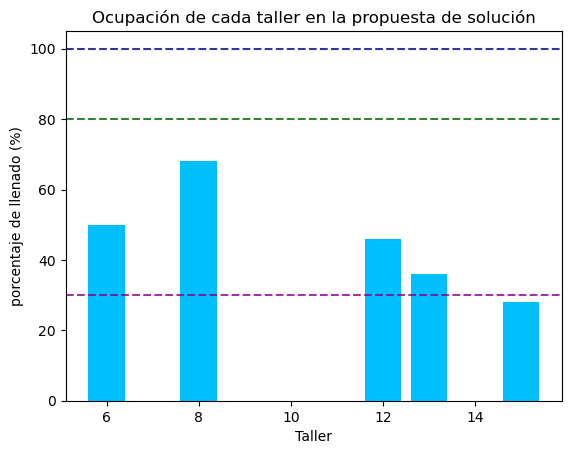

In [186]:
#contar cuanto se llenó cada taller
talleres = []
porcentajes = []
U_2 = U + U
capacidad_real_taller = defaultdict(int) #la key es el id del taller 0, 1,... y el value es la cantidad de alumnos asignados a este taller en la solución
for key, value in dic_asignaciones_realizadas.items():
    for taller in value:
       capacidad_real_taller[taller] += 1 

for taller, cantidad in sorted(capacidad_real_taller.items()):
    porcentaje = 100 * cantidad / U_2[taller]
    talleres.append(taller)
    porcentajes.append(porcentaje)
    print(f"El taller {taller} tiene {cantidad} alumnos, está un {100*(cantidad/U_2[taller])}% lleno")

plt.bar(talleres, porcentajes, color='deepskyblue')
plt.ylabel('porcentaje de llenado (%)')
plt.xlabel('Taller')
plt.title('Ocupación de cada taller en la propuesta de solución')
plt.axhline(100, color='darkblue', linestyle='--', linewidth=1.5, label='100%', alpha=0.8)
plt.axhline(80, color='darkgreen', linestyle='--', linewidth=1.5, label='80%', alpha=0.8)
plt.axhline(30, color='darkmagenta', linestyle='--', linewidth=1.5, label='80%', alpha=0.8)

## Cosas extra que podrían servir

In [ ]:
#si es infactible, ver la razón
"""
if model.status == GRB.INFEASIBLE:
    print("Modelo es infeasible. Buscando IIS...")
    
    # Computar IIS
    model.computeIIS()
    
    # Mostrar restricciones y variables en conflicto
    print("\nRestricciones en conflicto:")
    for c in model.getConstrs():
        if c.IISConstr:
            print(c.ConstrName)
    
    print("\nVariables involucradas en conflicto:")
    for v in model.getVars():
        if v.IISLB or v.IISUB:
            print(v.VarName)
"""

In [84]:
#para revisar
for key, value in dic_asignaciones_realizadas.items():
    if len(value) != 2:
        print(f"Al estudiante {key} se le asignó taller(es) {value}, verificar si es taller de 1 día completo o fallo")

Al estudiante 1 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 7 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 11 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 13 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 41 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 58 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 60 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 62 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 73 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 74 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 96 se le asignó taller(es) [9], verifi

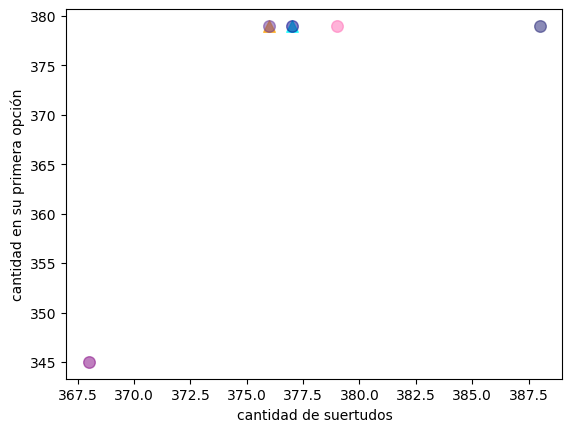

In [38]:
###comparar resultados pesos
pesos_1 = [388, 379, 257] #10, 5, 3
pesos_2 = [377, 379, 268] #3, 2, 1
pesos_3 = [376, 379, 269] #10.000, 100, 1
pesos_4 = [376, 379, 269] #100, 10, 1 
pesos_5 = [377, 379, 268] #10, 2, 1
pesos_6 = [368, 345, 320] #16, 15, 5
pesos_7 = [379, 379, 266] #8, 4, 2

fig, ax = plt.subplots()
ax.scatter(pesos_1[0], pesos_1[1], marker='o', c='midnightblue', alpha=0.5, s=70)
ax.scatter(pesos_2[0], pesos_2[1], marker='^', c='cyan', alpha=0.7, s=70)
ax.scatter(pesos_3[0], pesos_3[1], marker='^', c='orange', alpha=0.7, s=70)
ax.scatter(pesos_4[0], pesos_4[1], marker='o', c='rebeccapurple', alpha=0.5, s=70)
ax.scatter(pesos_5[0], pesos_5[1], marker='o', c='darkblue', alpha=0.5, s=70)
ax.scatter(pesos_6[0], pesos_6[1], marker='o', c='purple', alpha=0.5, s=70)
ax.scatter(pesos_7[0], pesos_7[1], marker='o', c='hotpink', alpha=0.5, s=70)

ax.set_xlabel('cantidad de suertudos')
ax.set_ylabel('cantidad en su primera opción')

plt.show()
#colores: https://matplotlib.org/stable/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py

In [86]:
#revisar que esté bien
suma_AM = 0
suma_PM = 0
for taller in talleres_AM:
    suma_AM += capacidad_real_taller[taller]
for taller in talleres_PM:
    suma_PM += capacidad_real_taller[taller]
print(suma_AM)
print(suma_PM)

392
392


### Visualizar algunas asignaciones de talleres vs lo que eligió

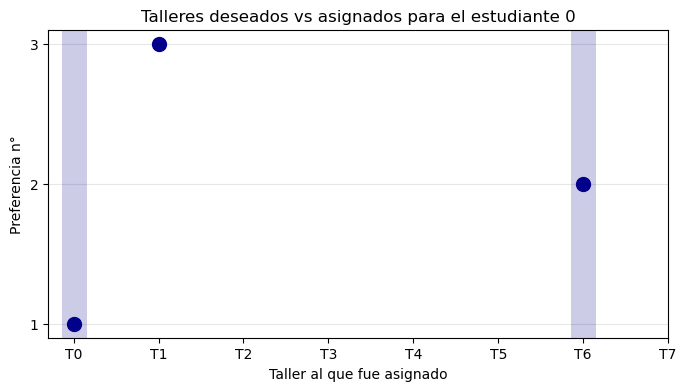

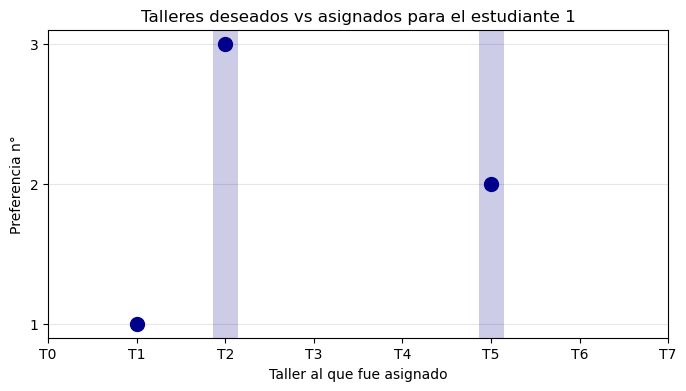

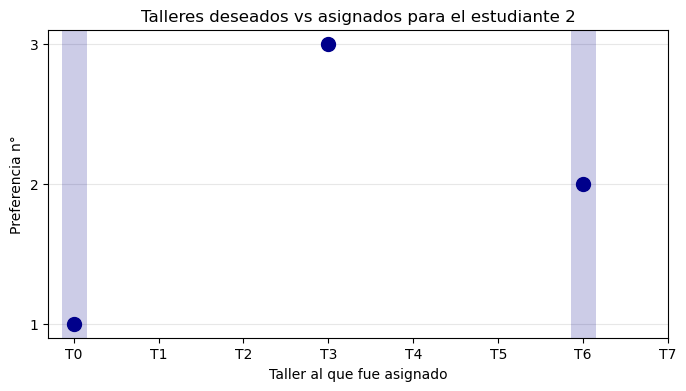

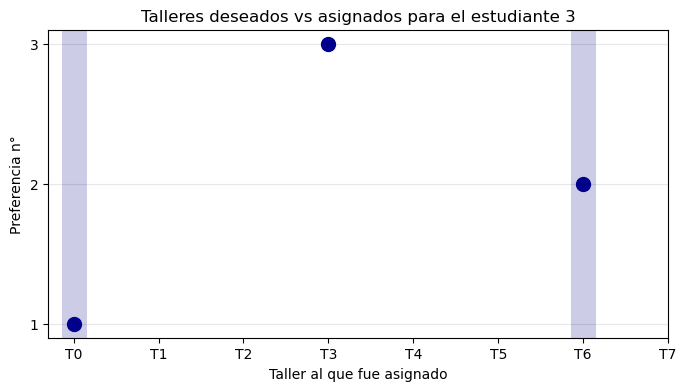

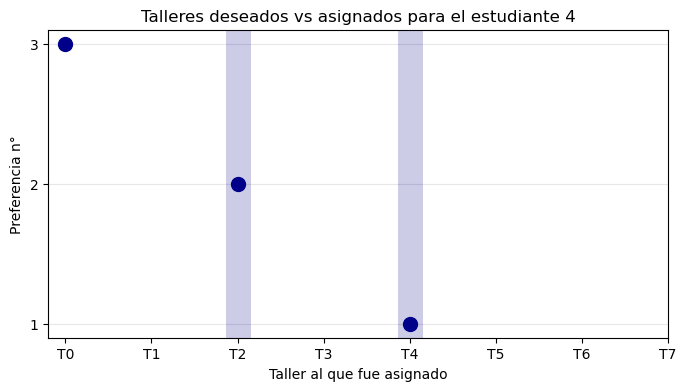

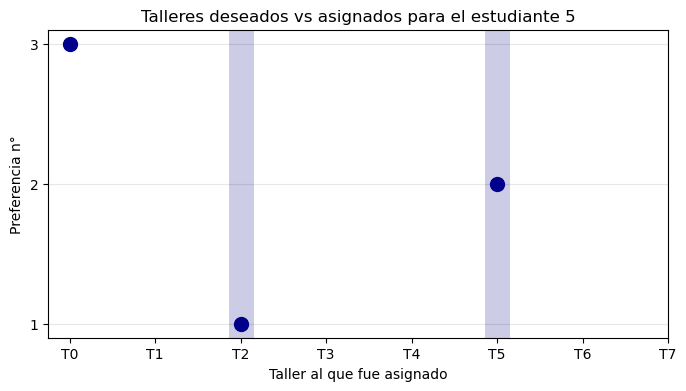

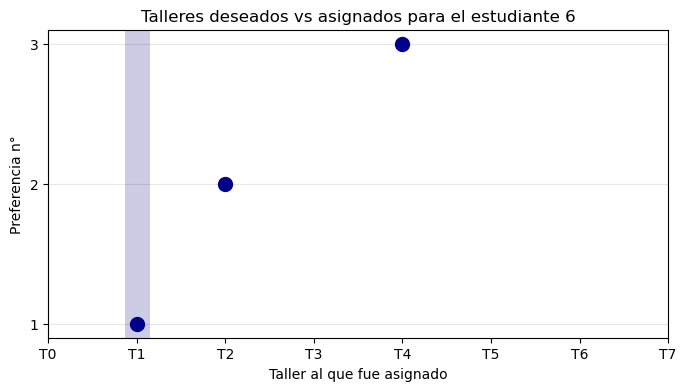

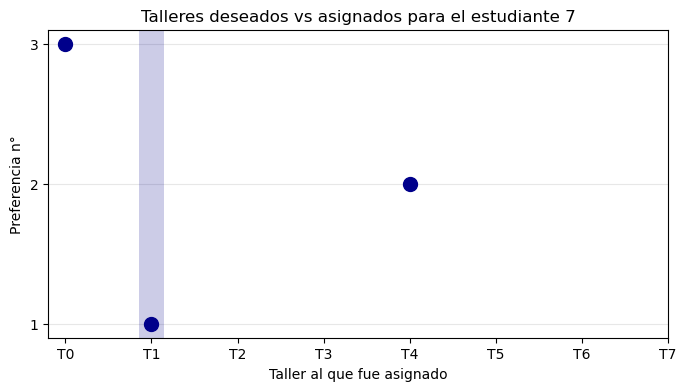

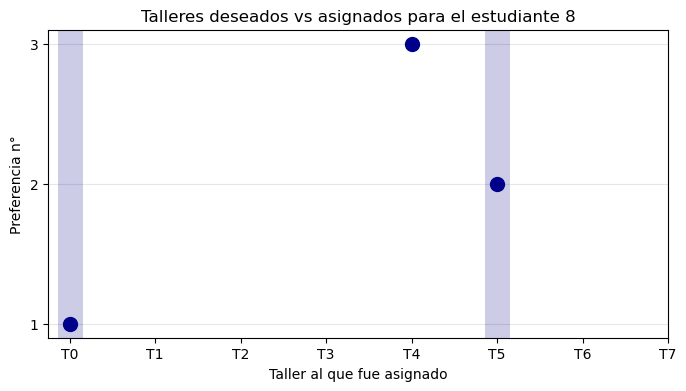

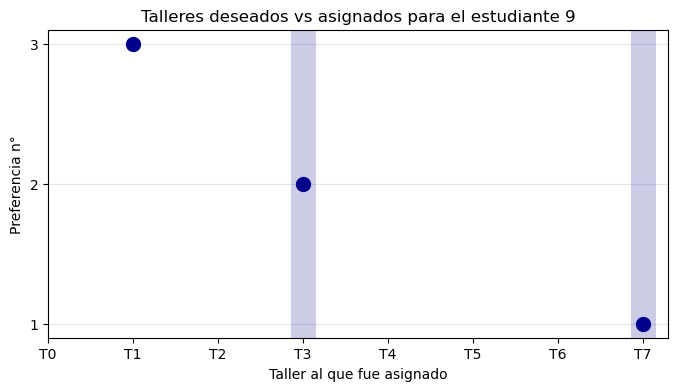

In [73]:
#visualizar la asignación de talleres
talleres = ['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
#para los estudiantes 0 al 9 muestra los talleres que quería y a los que fue asignado
for i in range(10):
    n_estudiante = i
    preferencias = util.get_dict(pref_m_aal, n_estudiante) #preferencia, taller
    asignados = dic_asignaciones_realizadas_mod[i] #asignaciones que se les dio, en mod
    
    plt.figure(figsize=(8, 4))
    #sombrear las columnas de los talleres asignados
    for t in asignados:
        plt.axvline(x=t, color='darkblue', alpha=0.2, linewidth=18, label='Asignado' if t == asignados[0] else "")
    
    #marcar los puntos de las preferencias
    for pref, t in preferencias.items():
        plt.scatter(t, pref, color='darkblue', s=100, zorder=3, label='Quería' if pref == 1 else "")
    
    plt.xticks(range(len(talleres)), talleres)
    plt.yticks(range(1, 4))
    plt.ylabel('Preferencia n°')
    plt.xlabel('Taller al que fue asignado')
    plt.title(f'Talleres deseados vs asignados para el estudiante {i}')
    #plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

<br><br><br><br><br><br><br><br><br><br>

# Estudiar por orden de llegada

Aca primero necesitaríamos alguna forma de seleccionar los talleres que se harían:

1. Hacer talleres con mayoría.
2. Probar combinaciones y elegir mejor: Hay 1575 formas de asignar

In [53]:
pref = pref_m_aal
(S, T, H, C, U, t_pref, D, p) = util.get_par(pref)

print("Hay", len(pref), "estudiantes, considerar esto al elegir capacidad y número de talleres")

talleres_AM_realizar = [0, 1, 3, 4, 6, 5] 
talleres_PM_realizar = [0, 1, 2, 4, 6, 7] 
dia_completo = [1]

Hay 393 estudiantes, considerar esto al elegir capacidad y número de talleres


In [95]:
def asignar(estudiante, cupos_restantes_AM, cupos_restantes_PM, t_pref, dict_asignacion_llegada, dia_completo):
    pref_1 = t_pref[estudiante][1]
    pref_2 = t_pref[estudiante][2]
    pref_3 = t_pref[estudiante][3]

    asignacion_AM = False
    asignacion_PM = False

    if pref_1 in cupos_restantes_AM.keys() and pref_1 in cupos_restantes_PM.keys():
        if (pref_1 in dia_completo) & (cupos_restantes_AM[pref_1] > 0) & (cupos_restantes_PM[pref_1] > 0):
            dict_asignacion_llegada[estudiante].append(pref_1)
            cupos_restantes_AM[pref_1] -= 1
            cupos_restantes_PM[pref_1] -= 1
            return cupos_restantes_AM, cupos_restantes_PM, dict_asignacion_llegada

    if pref_1 in cupos_restantes_AM.keys():
        if cupos_restantes_AM[pref_1] > 0:
            dict_asignacion_llegada[estudiante].append(pref_1)
            cupos_restantes_AM[pref_1] -= 1
            asignacion_AM = True
        elif pref_1 in cupos_restantes_PM.keys():
            if cupos_restantes_PM[pref_1] > 0:
                dict_asignacion_llegada[estudiante].append(pref_1)
                cupos_restantes_PM[pref_1] -= 1
                asignacion_PM = True

    if pref_2 in cupos_restantes_AM.keys() and pref_2 in cupos_restantes_PM.keys():
        if (pref_2 in dia_completo) & (cupos_restantes_AM[pref_2] > 0) & (cupos_restantes_PM[pref_2] > 0) & (not asignacion_AM) & (not asignacion_PM):
            dict_asignacion_llegada[estudiante].append(pref_2)
            cupos_restantes_AM[pref_2] -= 1
            cupos_restantes_PM[pref_2] -= 1
            return cupos_restantes_AM, cupos_restantes_PM, dict_asignacion_llegada

    if pref_2 in cupos_restantes_AM.keys():
        if (cupos_restantes_AM[pref_2] > 0) & (not asignacion_AM):
            dict_asignacion_llegada[estudiante].append(pref_2)
            cupos_restantes_AM[pref_2] -= 1
            asignacion_AM = True
        elif pref_2 in cupos_restantes_PM.keys():
            if (cupos_restantes_PM[pref_2] > 0) & (not asignacion_PM):
                dict_asignacion_llegada[estudiante].append(pref_2)
                cupos_restantes_PM[pref_2] -= 1
                asignacion_PM = True

    if pref_3 in cupos_restantes_AM.keys() and pref_3 in cupos_restantes_PM.keys():
        if (pref_3 in dia_completo) & (cupos_restantes_AM[pref_3] > 0) & (cupos_restantes_PM[pref_3] > 0) & (not asignacion_AM) & (not asignacion_PM):
            dict_asignacion_llegada[estudiante].append(pref_3)
            cupos_restantes_AM[pref_3] -= 1
            cupos_restantes_PM[pref_3] -= 1
            return cupos_restantes_AM, cupos_restantes_PM, dict_asignacion_llegada

    if pref_3 in cupos_restantes_AM.keys():
        if (cupos_restantes_AM[pref_3] > 0) & (not asignacion_AM):
            dict_asignacion_llegada[estudiante].append(pref_3)
            cupos_restantes_AM[pref_3] -= 1
            asignacion_AM = True
        elif pref_3 in cupos_restantes_PM.keys():
            if (cupos_restantes_PM[pref_3] > 0) & (not asignacion_PM):
                dict_asignacion_llegada[estudiante].append(pref_3)
                cupos_restantes_PM[pref_3] -= 1
                asignacion_PM = True


    return cupos_restantes_AM, cupos_restantes_PM, dict_asignacion_llegada

In [96]:
dict_asignacion_llegada = dict()
for i in range(len(pref)):
    dict_asignacion_llegada[i] = []

capacidad_sala = 70
cupos_restantes_AM = dict()
cupos_restantes_PM = dict()

for i in talleres_AM_realizar:
    cupos_restantes_AM[i] = capacidad_sala

for i in talleres_PM_realizar:
    cupos_restantes_PM[i] = capacidad_sala
    
for estudiante in range(len(pref)):
    cupos_restantes_AM, cupos_restantes_PM, dict_asignacion_llegada = asignar(estudiante, cupos_restantes_AM, cupos_restantes_PM, t_pref, dict_asignacion_llegada, dia_completo)

In [108]:
cupos_restantes_PM

{0: 0, 1: 0, 2: 70, 4: 0, 6: 0, 7: 70}

In [99]:
S = range(len(pref))
contador_suertudo = 0
contador_no = 0
contador = 0

for s in range(len(S)):
    asignados = dict_asignacion_llegada[s]  
    prefs_vals = set(t_pref[s].values())     

    #todos los asignados están entre los valores preferidos
    if all(a in prefs_vals for a in asignados):
        contador_suertudo += 1
    else:
        contador_no += 1
        print(s, prefs_vals, asignados)
    contador += 1
print("\n")
print("Total suertudos:", contador_suertudo, contador_suertudo/len(S))
print(f"Hay {contador_no} estudiantes que quedaron en algo que no pidieron (al menos 1 taller), esto es el {contador_no/n_alumnos} de 1")




Total suertudos: 393 1.0
Hay 0 estudiantes que quedaron en algo que no pidieron (al menos 1 taller), esto es el 0.0 de 1


In [101]:
contador_primera = 0
contador_segunda = 0
for s in range(len(S)):
    if (t_pref[s][1] in dict_asignacion_llegada[s]):
        contador_primera += 1 #quedó en top 1
    if (t_pref[s][2] in dict_asignacion_llegada[s]):
        contador_segunda += 1 #quedó en top2
print("En 1era opcion", contador_primera)
print("En 2nda opcion", contador_segunda)

En 1era opcion 291
En 2nda opcion 206


In [102]:
p = [10, 5, 3]
def obj_ind(estudiante):
    suma = 0
    pref_1 = t_pref[estudiante][1]
    pref_2 = t_pref[estudiante][2]
    pref_3 = t_pref[estudiante][3]

    if pref_1 in dict_asignacion_llegada[estudiante]:
        suma += p[0]
        if pref_1 in dia_completo:
            suma += p[0]

    if pref_2 in dict_asignacion_llegada[estudiante]:
        suma += p[1]
        if pref_2 in dia_completo:
            suma += p[1]

    if pref_3 in dict_asignacion_llegada[estudiante]:
        suma += p[2]
        if pref_3 in dia_completo:
            suma += p[2]

    return suma

In [103]:
valor_objetivo = 0

for estudiante in S:
    valor_objetivo += obj_ind(estudiante)

In [105]:
valor_objetivo / (len(S) - 1)

12.841836734693878